<a href="https://colab.research.google.com/github/smartdesignlab/SDL_teaching/blob/main/KAIST_SDL_3_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3. Multi-Objective Optimization with Generative AI (DDIM) & Predictive AI (CNN) via NSGA-2**

![](https://drive.google.com/uc?id=1IDICtMIUyU0ESoKNUOWMSZkiFVyuNZ51)

- A **pre-trained CNN model** that predicts two compliance values (objectives).
- A **pre-trained UNet model** with a DDIM scheduler for image generation.

**Overview**:  
1) Import libraries and set up environment.  
2) Load pre-trained models (DDIM-based UNet & CNN predictor).  
3) Generate structures from noise using DDIM.  
4) Predict compliance values with CNN.  
5) Optimize using NSGA-2.  
6) Visualize and save results.  

## 1) Import Libraries and Environment Setup

### **| Load Pre-trained model**

In [ ]:
predictor_path = './Predictor_CNN.pth'
generator_path = './Generator_DDIM.pth'

!gdown 1yV_yQ7J5oOOEVKqDrQVadDVNegdrSbMR -O {predictor_path}
!gdown 1pDiVYvrDcdYb5EeVPTCKzmMCpDzrUtui -O {generator_path}

!ls -lh {predictor_path}
!ls -lh {generator_path}

Downloading...
From: https://drive.google.com/uc?id=1yV_yQ7J5oOOEVKqDrQVadDVNegdrSbMR
To: /content/Predictor_CNN.pth
100% 865k/865k [00:00<00:00, 59.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1pDiVYvrDcdYb5EeVPTCKzmMCpDzrUtui
From (redirected): https://drive.google.com/uc?id=1pDiVYvrDcdYb5EeVPTCKzmMCpDzrUtui&confirm=t&uuid=3005daf7-b3c5-4a73-b999-a2af6de24178
To: /content/Generator_DDIM.pth
100% 176M/176M [00:01<00:00, 138MB/s]
-rw-r--r-- 1 root root 845K Jan 31 08:01 ./Predictor_CNN.pth
-rw-r--r-- 1 root root 168M Jan 30 05:47 ./Generator_DDIM.pth


In [ ]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 11.1 MB/s eta 0:00:00


### **| Import python libraries**

In [ ]:
import os
import csv
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import math
from deap import base, creator, tools
from diffusers import DDIMScheduler
from diffusers.models import UNet2DModel

# For inline image display (optional)
from IPython.display import Image as DispImage, display

# Use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device in use:", device)

def set_seed(seed=42):
    """Fix random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def sigmoid_filter(image: np.ndarray, alpha: float = 10.0):
    image = (image + 1.0) / 2.0  # [-1, 1] → [0, 1]
    contrasted = 1 / (1 + np.exp(-alpha * (image - 0.5)))
    contrasted = (contrasted * 255).clip(0, 255).astype(np.uint8)
    return contrasted

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

PyTorch version: 2.5.1+cu124
CUDA available: True
Device in use: cuda:0


## 2) Load the Pre-trained Models
### **| UNet (DDIM)**
We load our DDIM-based generator (`UNet2DModel`) for reverse diffusion from noise to final structure. The scheduler is initialized using `DDIMScheduler`.

In [ ]:
# Diffusion settings
num_inference_steps = 50
eta = 0.0

# Load the UNet model
unet = UNet2DModel(
    sample_size=56,
    in_channels=1,
    out_channels=1,
    layers_per_block=1,
    block_out_channels=[64, 128, 256, 512],
).to(device)

if os.path.exists(generator_path):
    unet.load_state_dict(torch.load(generator_path, map_location=device))
    print(f"Model loaded from {generator_path}")
else:
    raise FileNotFoundError(f"Model file not found at {generator_path}")

# Initialize the DDIM scheduler
scheduler = DDIMScheduler(num_train_timesteps=600)
scheduler.set_timesteps(num_inference_steps, eta)

<ipython-input-5-cad5190e5780>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet.load_state_dict(torch.load(generator_path, map_location=device))


Model loaded from ./Generator_DDIM.pth


### **| CNN Predictor**
Our CNN model takes a **56x56** grayscale image as input and outputs two compliance values, `(Comp1, Comp2)`. The model is loaded from a saved `.pth` file. Adjust the checkpoint path as needed.

In [ ]:
class Predictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # After three pooling layers, feature map size is (32, 7, 7)
        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # (Compliance1, Compliance2)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1) # Flatten
        x = self.fc_layers(x)
        return x

# Load the pre-trained CNN
predictor = Predictor().to(device)
if os.path.exists(predictor_path):
    predictor.load_state_dict(torch.load(predictor_path, map_location=device))
    predictor.eval()
    print(f"Loaded compliance predictor from {predictor_path}")
else:
    raise FileNotFoundError(f"Predictor file not found at {predictor_path}")

Loaded compliance predictor from ./Predictor_CNN.pth


<ipython-input-4-3c315c655ed0>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  predictor.load_state_dict(torch.load(predictor_path, map_location=device))


## 3) Generation from Noise
Given an input noise (size 56x56, range [-1,1]), we perform reverse diffusion steps to obtain the final structure via the UNet + DDIM.

In [ ]:
@torch.no_grad()
def generate_image_from_noise(noise: torch.Tensor) -> torch.Tensor:
    """
    input: noise (1, 1, 56, 56)
    return: generated image (1, 1, 56, 56)
    """
    start_time = time.time()

    for t in scheduler.timesteps:
        t_tensor = torch.tensor(t, dtype=torch.long).to(device) # timestep -> torch long tensor
        model_output = unet(noise, t_tensor).sample  # (B, 1, 56, 56)
        noise = scheduler.step(model_output, t_tensor, noise).prev_sample # denoising step

    end_time = time.time()
    elapsed_time = end_time - start_time
    return noise.clamp(-1.0, 1.0)

## 4) Evaluate Compliance via CNN
The **evaluate_compliance** function:
1. Converts a noise vector into a 2D noise tensor.
2. Generates an image from noise using the UNet.
3. Passes the generated image to our CNN `predictor`.
4. Returns two compliance values `(comp1, comp2)`.

In [ ]:
@torch.no_grad()
def evaluate_compliance(noise_vector: np.ndarray):
    """
    Maps a noise vector to two compliance values via UNet + CNN.
    noise_vector: NSGA-2 individual (gene) represented as noise in the range [-1, 1]
    """
    # 1) Noise Vector -> Tensor
    noise_tensor = torch.from_numpy(noise_vector).float().view(1, 1, 56, 56).to(device)

    # 2) Generate image via DDIM
    gen_image = generate_image_from_noise(noise_tensor)  # (1,1,56,56)

    # 3) Predict compliance
    comp_pred = predictor(gen_image)  # shape (1,2)
    comp1_norm, comp2_norm = comp_pred[0, 0].item(), comp_pred[0, 1].item()

    # 4) Denormalize (example scaling)
    compliance_min = [29.07, 11.95]
    compliance_max = [189.90, 191.65]

    comp1 = comp1_norm * (compliance_max[0] - compliance_min[0]) + compliance_min[0]
    comp2 = comp2_norm * (compliance_max[1] - compliance_min[1]) + compliance_min[1]

    return (comp1, comp2)

## 5) Multi-Objective Optimization using NSGA-2
Below is the setup for our multi-objective optimization:
1. **FitnessMin** (two objectives to minimize: compliance1, compliance2).
2. **Individual** defined as a NumPy array of shape (56x56=3136,).
3. Operators:
   - **init_ind**: Random uniform initialization in [-1,1].
   - **evaluate_compliance**: Our objective function.
   - **mate**: We use `tools.cxBlend`.
   - **mutate**: Gaussian mutation (`tools.mutGaussian`).
4. **select**: We use NSGA-2 (`tools.selNSGA2`).

### **| Define Fitness, Individuals, and Toolbox python**

In [ ]:
# NSGA-2 parameters
pop_size = 100   # Population size
n_gen = 100      # Number of generations
cxpb = 0.7       # Crossover probability
mutpb = 0.5      # Mutation probability
sigma = 0.3      # Mutation standard deviation

# 1) Fitness and Individual definitions
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))  # minimize (comp1, comp2)
creator.create("Individual", np.ndarray, fitness=creator.FitnessMin) # individual definitions

toolbox = base.Toolbox()

# 2) Initialization function
def init_ind(icls):
    """
    Creates a single individual with random noise in [-1,1].
    """
    array = np.random.uniform(-1, 1, size=(56*56,))
    return icls(array)

toolbox.register("individual", init_ind, creator.Individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# 3) Objective function (CNN + DDIM)
# This must be defined or imported:
#   evaluate_compliance(ind)
toolbox.register("evaluate", evaluate_compliance)

# 4) Crossover and mutation operators
toolbox.register("mate", tools.cxBlend, alpha=0.5) # cxBlend
# Add mutation noise to 5% of pixels based on 𝒩(0, 0.3²) distribution
toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=sigma, indpb=0.05)

# 5) NSGA-2 selection
toolbox.register("select", tools.selNSGA2)

### **| Initialize and Evaluate Population**

In [ ]:
# 1) Create initial population
pop = toolbox.population(n=pop_size)
print(f"Created initial population of size {pop_size}.")

# 2) Evaluate initial population
invalid_ind = [ind for ind in pop if not ind.fitness.valid]
fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit

print("Initial population evaluated.")

Created initial population of size 100.


<ipython-input-6-6ef38ea7bb5a>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t, dtype=torch.long).to(device)


Initial population evaluated.


<ipython-input-6-6ef38ea7bb5a>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t, dtype=torch.long).to(device)


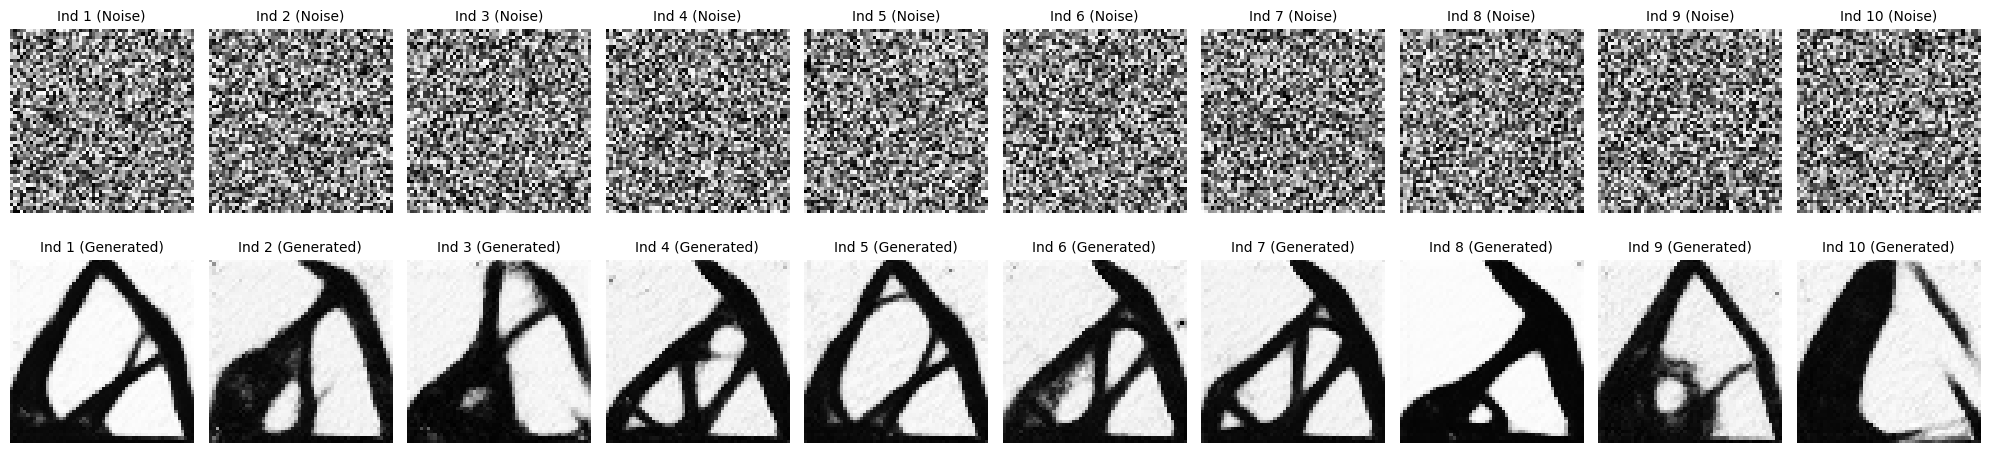

In [ ]:
num_samples = min(10, pop_size)
sample_population = pop[:num_samples]

fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 2, 5))

for i, ind in enumerate(sample_population):
    noise_vector = ind.reshape(56, 56)
    axes[0, i].imshow(noise_vector, cmap="gray", interpolation="nearest")
    axes[0, i].set_title(f"Ind {i+1} (Noise)", fontsize=10)
    axes[0, i].axis("off")

    noise_tensor = torch.from_numpy(ind).float().view(1, 1, 56, 56).to(device)
    gen_image = generate_image_from_noise(noise_tensor)
    img_np = gen_image.squeeze().cpu().numpy()

    filtered_img = sigmoid_filter(img_np)

    axes[1, i].imshow(filtered_img, cmap="gray", interpolation="nearest")
    axes[1, i].set_title(f"Ind {i+1} (Generated)", fontsize=10)
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

### **| NSGA-2 Evolution**

In [ ]:
for gen in range(n_gen):
    print(f"\n-- Generation {gen+1} --")

    # 1) Selection
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    # 2) Crossover
    for i in range(0, len(offspring), 2):
        if random.random() < cxpb and (i + 1) < len(offspring):
            toolbox.mate(offspring[i], offspring[i + 1])
            del offspring[i].fitness.values
            del offspring[i + 1].fitness.values

    # 3) Mutation
    for mutant in offspring:
        if random.random() < mutpb:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # 4) Re-evaluate invalid individuals
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # 5) Combine parent + offspring, select next generation
    pop = toolbox.select(pop + offspring, pop_size)

    # Print generation results
    fits = [ind.fitness.values for ind in pop]
    for i, f in enumerate(fits):
        print(f"Individual {i} => (comp1={f[0]:.4f}, comp2={f[1]:.4f})")

print("\nOptimization complete!")



-- Generation 1 --


<ipython-input-6-6ef38ea7bb5a>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t, dtype=torch.long).to(device)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.

-- Generation 52 --
Individual 0 => (comp1=62.5670, comp2=10.5953)
Individual 1 => (comp1=33.1371, comp2=33.2905)
Individual 2 => (comp1=34.8792, comp2=22.7515)
Individual 3 => (comp1=34.7185, comp2=30.9923)
Individual 4 => (comp1=50.6301, comp2=13.4253)
Individual 5 => (comp1=42.1430, comp2=14.0576)
Individual 6 => (comp1=36.4631, comp2=17.4871)
Individual 7 => (comp1=47.1597, comp2=13.4523)
Individual 8 => (comp1=44.9837, comp2=13.8738)
Individual 9 => (comp1=53.7114, comp2=12.6572)
Individual 10 => (comp1=35.9515, comp2=19.7702)
Individual 11 => (comp1=34.2415, comp2=32.9680)
Individual 12 => (comp1=39.5660, comp2=15.7933)
Individual 13 => (comp1=34.2919, comp2=31.4026)
Individual 14 => (comp1=56.9728, comp2=12.4824)
Individual 15 => (comp1=41.4434, comp2=14.1154)
Individual 16 => (comp1=51.4317, comp2=13.2663)
Individual 17 => (comp1=54.9804, comp2=12.5968)
Individual 18 => (comp1=35.2846, comp2=22.4561)
Individual 19 => (comp1=35.6185, comp2=21

### **| Pareto Front**

In [ ]:
fronts = tools.sortNondominated(pop, k=len(pop), first_front_only=True)
pareto_front = fronts[0]
pareto_front_sorted = sorted(pareto_front, key=lambda ind: ind.fitness.values[0])

print(f"Extracted Pareto front with {len(pareto_front_sorted)} individuals.")

Extracted Pareto front with 100 individuals.


### Save Pareto Front to CSV

In [ ]:
os.makedirs("final_results", exist_ok=True)
os.makedirs("final_results/solutions", exist_ok=True)

csv_path = os.path.join("final_results", "pareto_front.csv")
with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Index", "Comp1", "Comp2"])
    for i, ind in enumerate(pareto_front_sorted):
        comp1, comp2 = ind.fitness.values
        writer.writerow([i + 1, comp1, comp2])

print(f"Pareto front CSV saved at: {csv_path}")

Pareto front CSV saved at: final_results/pareto_front.csv


### Plot Pareto Front

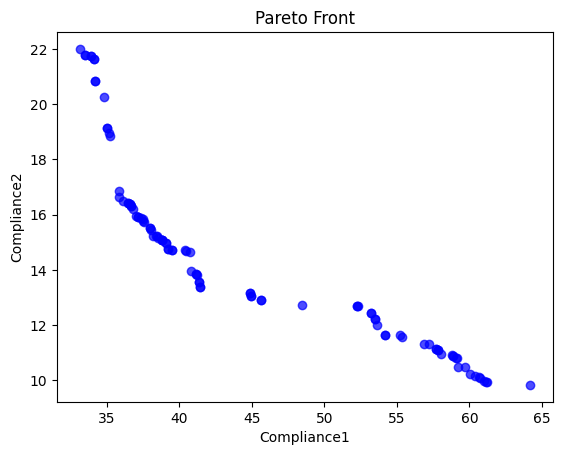

In [ ]:
# Plot Pareto Front
comp1_list = [ind.fitness.values[0] for ind in pareto_front]
comp2_list = [ind.fitness.values[1] for ind in pareto_front]

plt.figure()
plt.scatter(comp1_list, comp2_list, c="blue", alpha=0.7)
plt.xlabel("Compliance1")
plt.ylabel("Compliance2")
plt.title("Pareto Front")
plt.show()

### Pareto Solutions

<ipython-input-6-6ef38ea7bb5a>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t, dtype=torch.long).to(device)


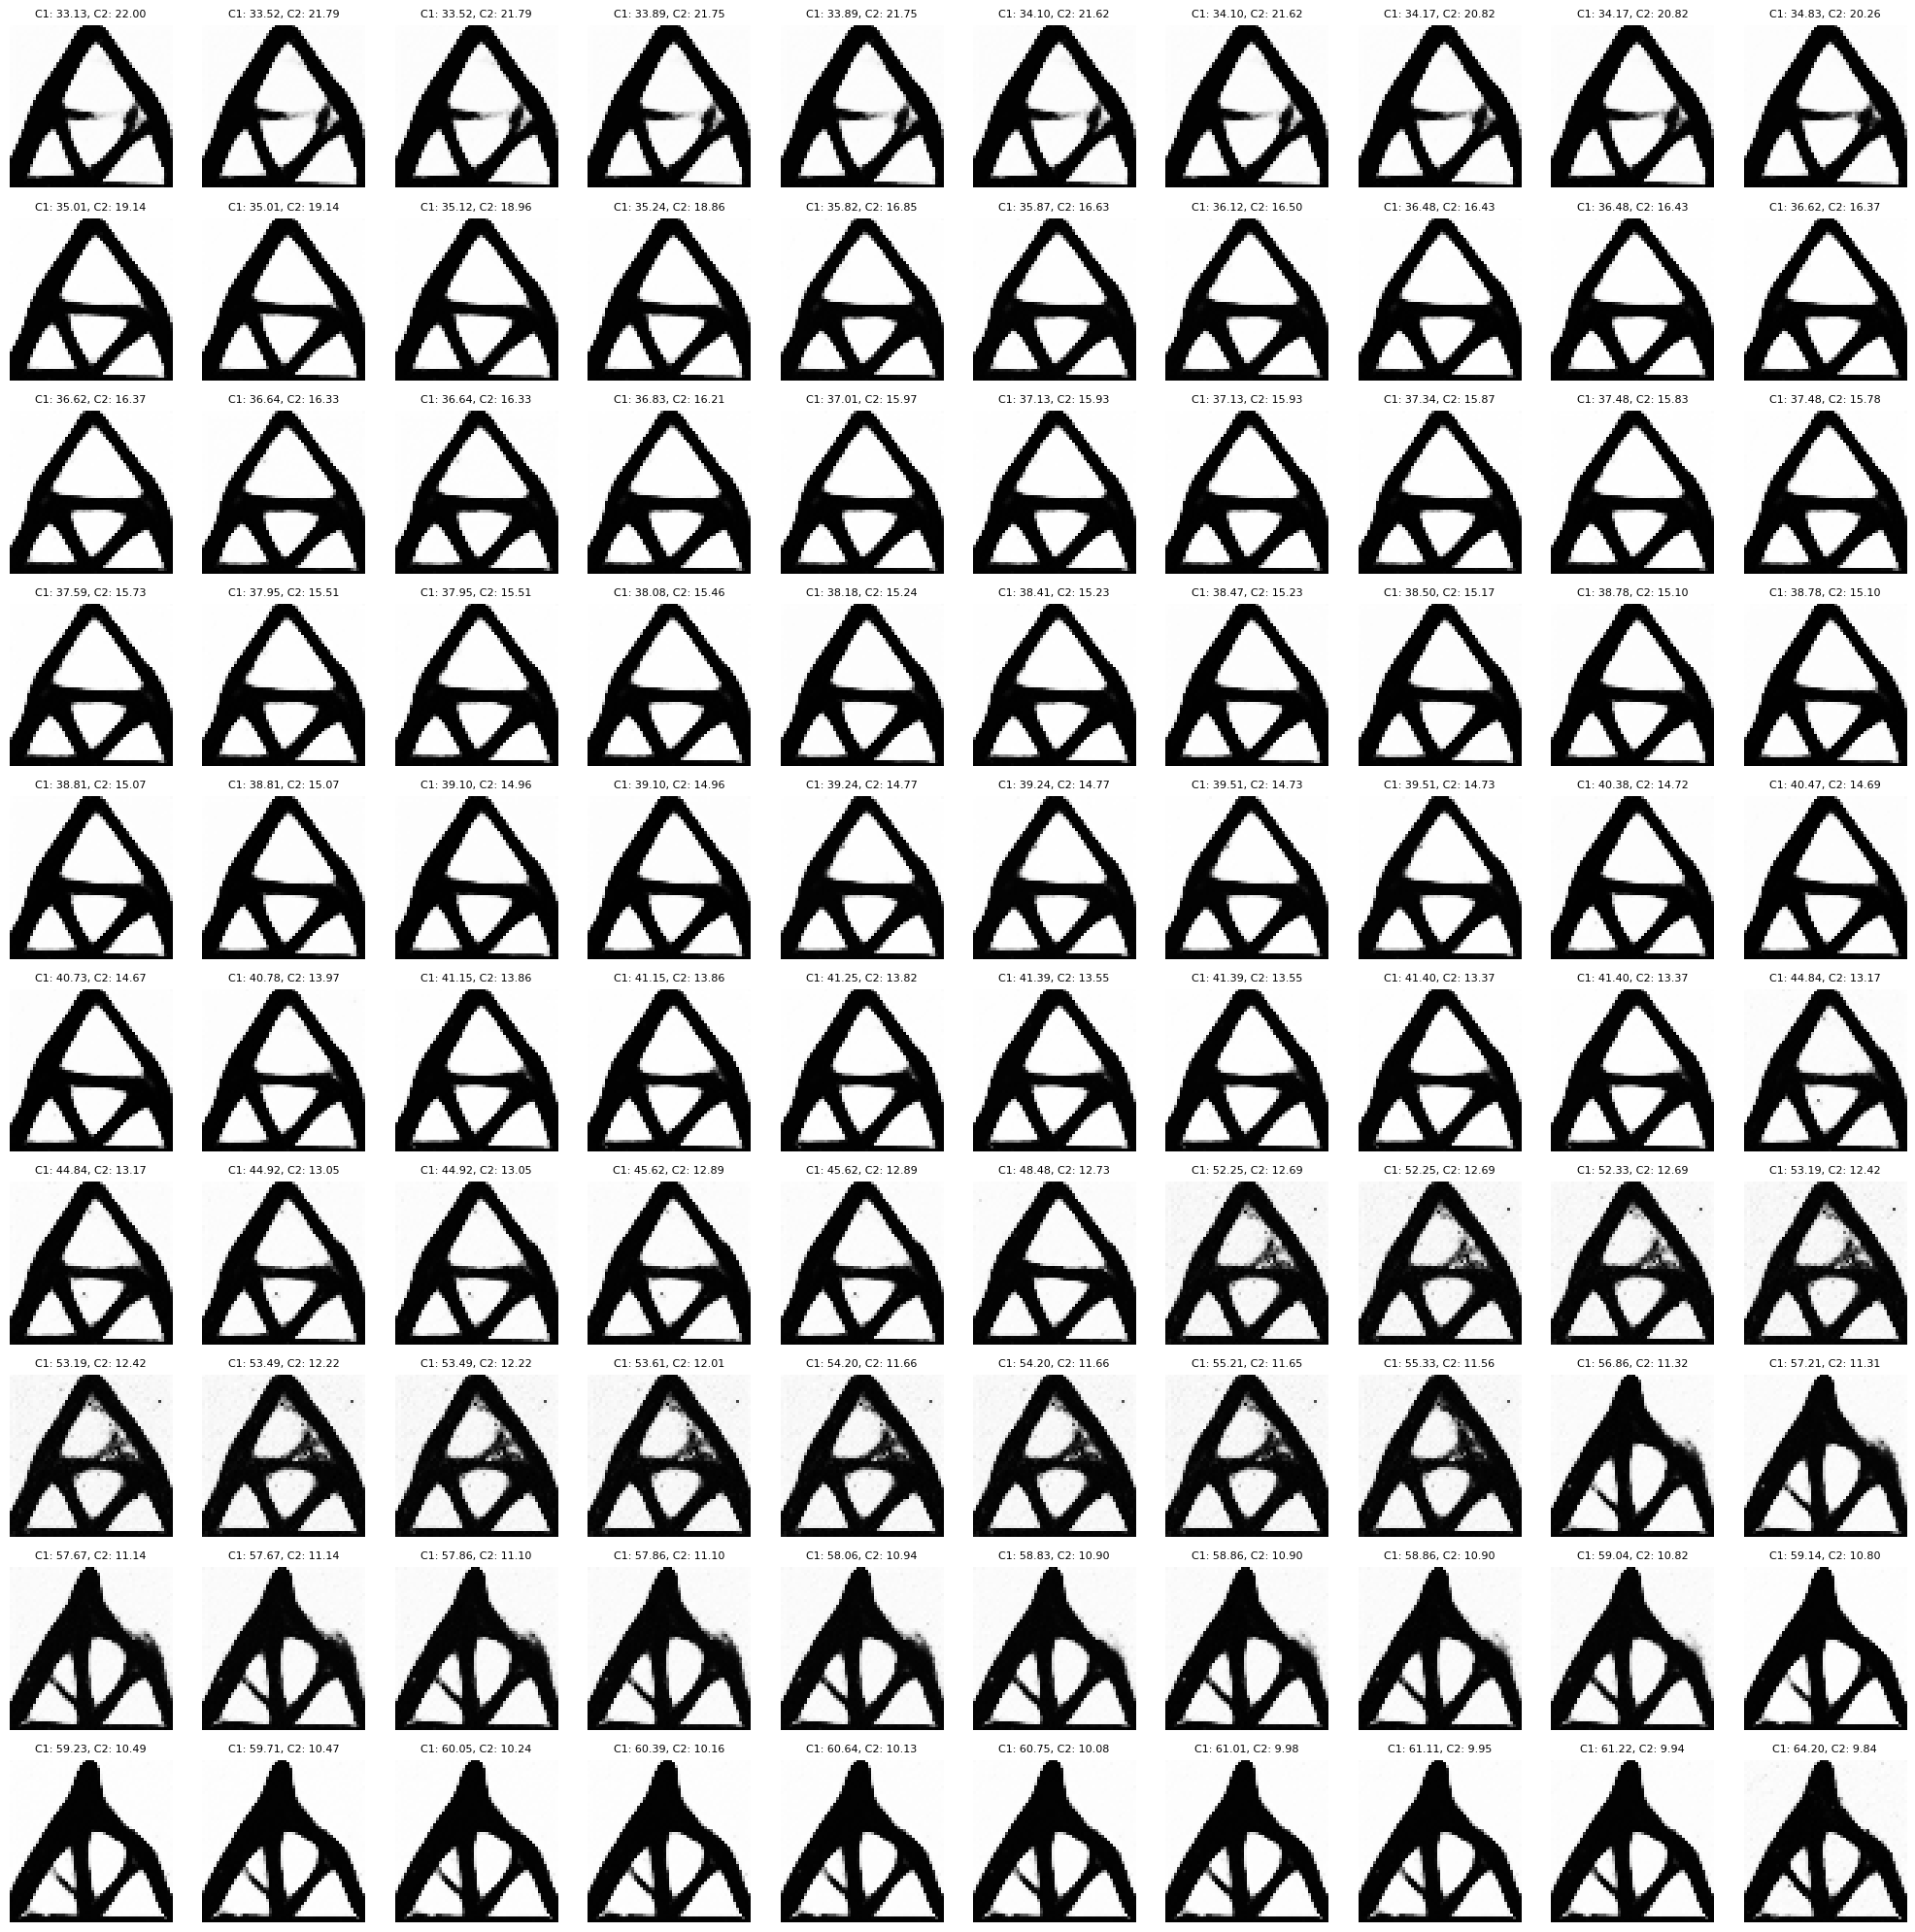

In [ ]:
grid_size = math.ceil(math.sqrt(len(pareto_front_sorted)))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 2, grid_size * 2))
axes = axes.flatten()

for idx, ind in enumerate(pareto_front_sorted):
    # Generate image from noise using UNet
    noise_vector = torch.from_numpy(ind).float().view(1, 1, 56, 56).to(device)
    gen_image = generate_image_from_noise(noise_vector)
    img_np = gen_image.squeeze().cpu().numpy()

    # Apply sigmoid filter for better contrast
    filtered_img = sigmoid_filter(img_np)

    image_path = os.path.join("final_results/solutions", f"solution_{idx+1}.png")
    plt.imsave(image_path, filtered_img, cmap="gray")

    # Plot the image
    axes[idx].imshow(filtered_img, cmap="gray", interpolation="nearest")
    axes[idx].set_title(f"C1: {ind.fitness.values[0]:.2f}, C2: {ind.fitness.values[1]:.2f}", fontsize=8)
    axes[idx].axis("off")

# Remove empty subplots
for idx in range(len(pareto_front_sorted), len(axes)):
    axes[idx].axis("off")

plt.tight_layout()
plt.show()